In [38]:
import tensorflow as tf

# load the model used for prediction the external contour
ex_cnt_model = tf.keras.models.load_model('unet_model')
in_cnt_model = tf.keras.models.load_model('internal_smaller_mask_unet_model')

In [39]:
# load the image
original_images_dir = 'data/original/'
heatmap_images_dir = 'data/heatmap/'

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_contour(mask: np.ndarray):
     # Apply thresholding
    ret, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    # sDefine structuring element (MORPH_RECT)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    # Erosion using MORPH_RECT structuring element
    erosion= cv2.erode(thresh, kernel, iterations=1)
    # Dilate using MORPH_RECT structuring element
    dilation = cv2.dilate(erosion, kernel, iterations=1)
    # Find contour using the eroded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Find the contour with the largest area
    contour = max(contours, key=cv2.contourArea)
    return contour

def predict_mask(img, model):
    # Predict the mask
    img = cv2.resize(img, (128, 128))
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)
    img = img / 255
    pred = model.predict(img)
    pred = tf.argmax(pred, axis=-1)
    pred = pred[..., tf.newaxis]
    pred = tf.squeeze(pred)
    pred = pred.numpy()
    pred = pred.astype(np.uint8) * 255
    return pred

In [37]:
# Find contours for image P1MF1_C
img = cv2.imread(original_images_dir + 'test/P1MF1_C.png')
heatmap_img = cv2.imread(heatmap_images_dir + 'test/P1MF1_C.png')
ex_cnt_mask = predict_mask(img, ex_cnt_model)
in_cnt_mask = predict_mask(heatmap_img, in_cnt_model)
ex_cnt = get_contour(ex_cnt_mask)
in_cnt = get_contour(in_cnt_mask)
ex_cnt = cv2.convexHull(ex_cnt)
in_cnt = cv2.convexHull(in_cnt)
ex_cnt = ex_cnt * (img.shape[0] / 128)
in_cnt = in_cnt * (img.shape[0] / 128)

# Find the center of mass of the external contour and internal contour
ex_cnt = ex_cnt.reshape(-1, 2)
M = cv2.moments(ex_cnt)
ex_cnt_center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
in_cnt = in_cnt.reshape(-1, 2)
M = cv2.moments(in_cnt)
in_cnt_center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

# Go back to the original external contour and internal contour
ex_cnt = ex_cnt.reshape(-1, 1, 2)
in_cnt = in_cnt.reshape(-1, 1, 2)

# Find the vector from the center of mass of the external contour to the center of mass of the internal contour
vector = (in_cnt_center[0] - ex_cnt_center[0], in_cnt_center[1] - ex_cnt_center[1])

# Find the equation in polar coordinates of the vector
rho = np.sqrt(vector[0] ** 2 + vector[1] ** 2)
theta = np.arctan2(vector[1], vector[0])

# Find tthe points that are in the external contour and match the equation of the vector
points = []
eps1 = 5
eps2 = 0.1
for point in ex_cnt:
    point = point[0]
    x = point[0]
    y = point[1]
    if abs(np.sqrt((x - ex_cnt_center[0]) ** 2 + (y - ex_cnt_center[1]) ** 2) - rho) < 2000:
        if abs(np.arctan2(y - ex_cnt_center[1], x - ex_cnt_center[0]) - theta) < 2000:
            points.append((x, y))

# Find the points that are in the side of the internal contour most of points are
# and the side of the internal contour that is most of points are
left_points = []
right_points = []
for point in points:
    if np.cross(vector, (point[0] - ex_cnt_center[0], point[1] - ex_cnt_center[1])) > 0:
        left_points.append(point)
    else:
        right_points.append(point)

left_points = np.array(left_points)
right_points = np.array(right_points)
# check where the most of points in the internal contour, left or right
left_points_in_in_cnt = cv2.pointPolygonTest(in_cnt, (left_points[:, 0].mean(), left_points[:, 1].mean()), False)
right_points_in_in_cnt = cv2.pointPolygonTest(in_cnt, (right_points[:, 0].mean(), right_points[:, 1].mean()), False)
if left_points_in_in_cnt > right_points_in_in_cnt:
    points = left_points
else:
    points = right_points

external_contour_points = np.array(ex_cnt)

# find an ellipse that his one edge is the vector perpendicular to the vector of the external contour
# and the other edge is the vector from the center of mass of the external contour to the center of mass of the internal contour
# and the ellipse cover most of the points in the internal contour, and less points in the external contour
# and the ellipse is the smallest ellipse that cover all the points in the internal contour

# perpendicular vector to the vector of the external contour
pendicular_vector = (-vector[1], vector[0])

# Normalize the axes
major_axis = vector / np.linalg.norm(vector)
minor_axis = pendicular_vector / np.linalg.norm(pendicular_vector)

# Initialize the axes lengths
a = b = np.linalg.norm(vector)  # Start with a circle of diameter equal to the distance between centers

# Function to check if a point is inside the ellipse
def point_in_ellipse(point, center, a, b, major_axis, minor_axis):
    shifted_point = point - center
    x = np.dot(shifted_point, major_axis)
    y = np.dot(shifted_point, minor_axis)
    return (x / a) ** 2 + (y / b) ** 2 <= 1

# Iteratively find the smallest ellipse covering all points in the internal contour
epsilon = 0.1  # Increment for adjusting ellipse size
while True:
    if all(point_in_ellipse(point, ex_cnt_center, a, b, major_axis, minor_axis) for point in in_cnt):
        b -= epsilon  # Try reducing the minor axis length
    else:
        b += epsilon  # Increase the minor axis length until all points are included
        break

# Find the angle of rotation for the ellipse
angle = np.arctan2(major_axis[1], major_axis[0]) * (180 / np.pi)

# Drawing the ellipse
ellipse = (ex_cnt_center, (int(2*a), int(2*b)), angle)
ellipse_img = img.copy()
cv2.ellipse(ellipse_img, ellipse, (0, 255, 0), 2)

1/1 [==============================] - 1s 1s/step


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\geometry.cpp:103: error: (-215:Assertion failed) total >= 0 && (depth == CV_32S || depth == CV_32F) in function 'cv::pointPolygonTest'


1/1 [==============================] - 0s 40ms/step


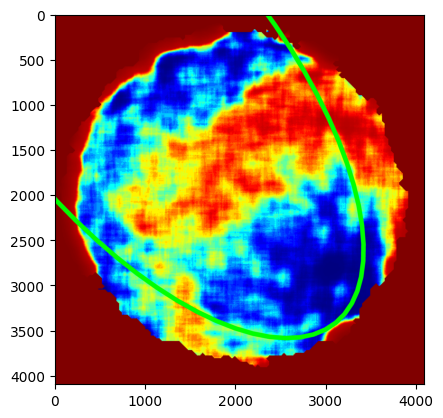

In [56]:
import cv2
import numpy as np

def read_image(file_path):
    return cv2.imread(file_path)

def find_center_of_mass(contour):
    M = cv2.moments(contour)
    return (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

def calculate_vector(center1, center2):
    return (center2[0] - center1[0], center2[1] - center1[1])

def is_point_near_line(point, line_start, line_end, eps1):
    # Convert tuples to numpy arrays
    point = np.array(point)
    line_start = np.array(line_start)
    line_end = np.array(line_end)

    # Calculate the directional vector of the line
    line_vec = line_end - line_start

    # Calculate the vector from the start of the line to the point
    point_vec = point - line_start

    # Calculate the cross product and the norm
    cross_prod = np.cross(line_vec, point_vec)
    norm_line_vec = np.linalg.norm(line_vec)

    # Calculate the distance from the point to the line
    distance = np.linalg.norm(cross_prod) / norm_line_vec

    # Check if the distance is within the threshold
    return abs(distance) <= eps1

def find_points_near_line(points, line_start, line_end, eps1):
    # Implement logic based on distance and angle criteria
    # Distance criteria
    points_near_line = []
    for point in points:
        if is_point_near_line(point, line_start, line_end, eps1):
            points_near_line.append(point)
    return np.array(points_near_line)

def is_point_on_left_or_right_side(point, line_start, line_end):
    # Convert tuples to numpy arrays
    point = np.array(point)
    line_start = np.array(line_start)
    line_end = np.array(line_end)

    # Implement logic based on distance and angle criteria
    # Angle criteria
    if np.cross(line_end - line_start, line_start - point) > 0:
        return 'left'
    else:
        return 'right'

def find_farthest_point(contour, center, axis_angle):
    """Find the farthest point on the contour from the center along a specified axis."""
    farthest_distance = 0
    for point in contour:
        # Project each point onto the specified axis
        vector = np.array(point[0]) - np.array(center)
        axis_vector = np.array([np.cos(np.radians(axis_angle)), np.sin(np.radians(axis_angle))])
        distance = np.dot(vector, axis_vector)
        farthest_distance = max(farthest_distance, abs(distance))
    return farthest_distance

def adjust_ellipse(contour, new_center, step_size=1, max_iterations=100000):
    new_center = new_center[0]
    # Fit initial ellipse
    ellipse = cv2.fitEllipse(contour)
    (x, y), (MA, ma), angle = ellipse

    for _ in range(max_iterations):
        # Calculate new major and minor axes lengths
        new_major_axis = find_farthest_point(contour, new_center, angle) * 2
        new_minor_axis = find_farthest_point(contour, new_center, angle + 90) * 2

        # Update the ellipse with the new parameters
        ellipse = (new_center, (new_major_axis, new_minor_axis), angle)

        # Check if the new axes cover the contour
        if new_major_axis >= MA and new_minor_axis >= ma:
            break

        # Increment the axes lengths
        MA += step_size
        ma += step_size

    return ellipse

# Main processing
original_img = read_image(original_images_dir + 'test/P2MF9_N.png')
heatmap_img = read_image(heatmap_images_dir + 'test/P2MF9_N.png')

ex_cnt_mask = predict_mask(original_img, ex_cnt_model)
in_cnt_mask = predict_mask(heatmap_img, in_cnt_model)

ex_cnt = get_contour(ex_cnt_mask)
in_cnt = get_contour(in_cnt_mask)

ex_cnt_center = find_center_of_mass(ex_cnt)
in_cnt_center = find_center_of_mass(in_cnt)

vector = calculate_vector(ex_cnt_center, in_cnt_center)

# Find points near the line
eps1 = 5
points_near_line = find_points_near_line(ex_cnt, ex_cnt_center, in_cnt_center, eps1)

# Find points on the left and right side of the line
left_points = []
right_points = []
for point in points_near_line:
    if is_point_on_left_or_right_side(point, ex_cnt_center, in_cnt_center) == 'left':
        left_points.append(point)
    else:
        right_points.append(point)

left_points = np.array(left_points)
right_points = np.array(right_points)

# Check if the center of mass of the internal contour is on the left or right side of the line
side = is_point_on_left_or_right_side(in_cnt_center, ex_cnt_center, in_cnt_center)
if side == 'left':
    points = left_points
else:
    points = right_points

sample_point = points[0]

ellipse = adjust_ellipse(in_cnt, sample_point)
(center1, center2, distance) = ellipse
scale_factor = original_img.shape[0] / 128
center1 = (int(center1[0] * scale_factor), int(center1[1] * scale_factor))
center2 = (int(center2[0] * scale_factor), int(center2[1] * scale_factor))
distance = int(distance * scale_factor)

scaled_ellipse = (center1, center2, distance)
# Replace the axis of the ellipse
# Find the angle of rotation for the ellipse
angle = np.arctan2(vector[1], vector[0]) * (180 / np.pi)
scaled_ellipse = (scaled_ellipse[0], scaled_ellipse[1], angle)

# Drawing the ellipse
ellipse_img = heatmap_img.copy()
cv2.ellipse(ellipse_img, scaled_ellipse, (0, 255, 0), 50)
# Scaling and preparing the contour
#in_cnt = in_cnt.reshape(-1, 2)
in_cnt = in_cnt * 32
in_cnt = in_cnt.astype(np.int32)
#cv2.drawContours(ellipse_img, [in_cnt], -1, (0, 255, 0), 50)


# Show the image
plt.imshow(ellipse_img)
plt.show()